# Monte Carlo Markov Chain example 


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

We start from Filicudi


Text(0.5, 1.0, 'rejected')

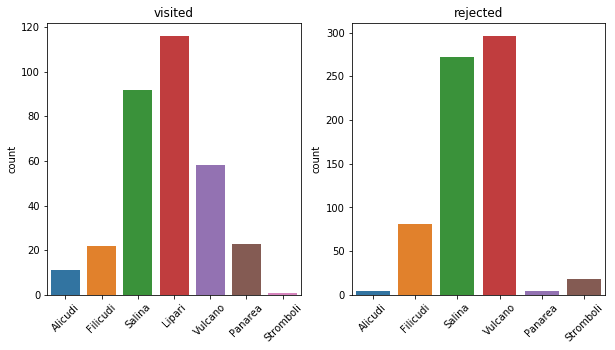

In [199]:
names = ['Alicudi','Filicudi','Salina','Lipari','Vulcano','Panarea','Stromboli']
sizes = [8,10,100,500,50,40,5]

def jump(p):
    a = np.random.uniform(0,1, 1)
    return p >= a


start = np.random.choice(names)
i0 = names.index(start)
print('We start from %s' %start)

visited = []
rejected = []
for i in range(1000):
    
    if i0 == 6:
        i1 = 5
    elif i0 == 0:
        i1 = 1
    else:
        i1=int(np.random.choice([i0-1,i0+1],1))
    #print(i1)
    #print('we propose to jump to %s' %(names[i1]))
    
    p_jump = sizes[i1]/sizes[i0]
    
    if jump(p_jump):
        i0 = i1   
        visited.append(i0)
    else:
        rejected.append(i1)

        

    #print('We are now in %s' %(names[i0]))

f,ax = plt.subplots(1,2,figsize=(10,5))
g0=sns.countplot(visited, ax= ax[0])
labels = [names[i] for i in g0.get_xticks()]
ax[0].set_xticklabels(labels, rotation  =  45)
ax[0].set_title('visited')

g1=sns.countplot(rejected, ax= ax[1])
labels = [names[int(i.get_text())] for i in g1.get_xticklabels()]
ax[1].set_xticklabels(labels, rotation  =  45)
ax[1].set_title('rejected')

Text(0.5, 0, 'Days')

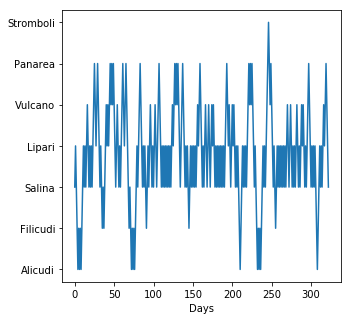

In [200]:
f,ax = plt.subplots(1, figsize=(5,5))
ax.plot(visited)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels(names)
ax.set_xlabel('Days')

# MCMC Metropolis-Hastings sampler


### Adapted from: https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a


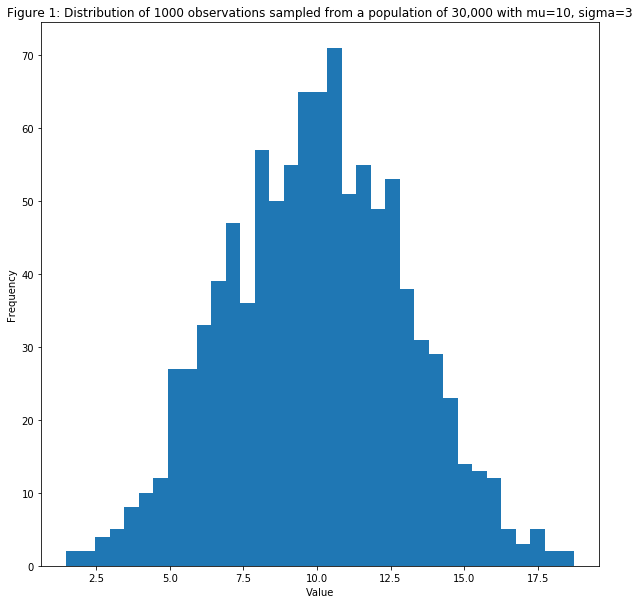

In [20]:

mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3")
mu_obs=observation.mean()

In [58]:

#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],1,(1,))]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    i_accepted=[]
    i_rejected=[]
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
            i_accepted.append(i)
            
        else:
            rejected.append(x_new)
            i_rejected.append(i)
                
    return np.array(accepted), np.array(rejected), np.array(i_accepted), np.array(i_rejected)

In [59]:
accepted, rejected, ia, ir = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 1000,observation,acceptance)


/home/viola/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/home/viola/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


In [60]:
print(len(accepted), len(rejected))
print(accepted)

10 990
[[   9.9732397   127.56466001]
 [   9.9732397    94.74063269]
 [   9.9732397    26.73368205]
 [   9.9732397    24.18819132]
 [   9.9732397    11.09990364]
 [   9.9732397     5.31586662]
 [   9.9732397     4.84050857]
 [   9.9732397     3.29444928]
 [   9.9732397     3.15384469]
 [   9.9732397     3.15793793]]


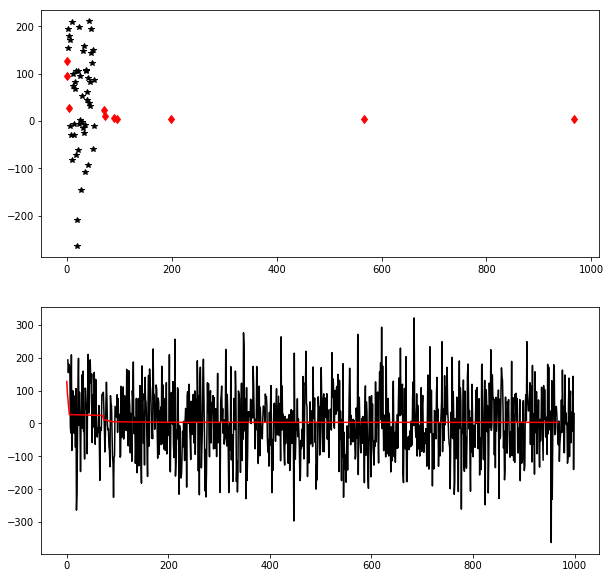

In [61]:
f,ax=plt.subplots(2,1, figsize=(10,10))
ax[0].plot(ia[0:50], accepted[:,1][0:50], 'rd')
ax[0].plot(ir[0:50],rejected[:,1][0:50], 'k*')

ax[1].plot(ir,rejected[0:,1], 'k')
ax[1].plot(ia,accepted[:,1], 'r')


